# Experiment 3: Mechanism Analysis - Batch Size & Data Ordering (CIFAR10)

## Experiment Goal
Understand the **mechanism** behind width's robustness by analyzing how batch size and data ordering affect poisoning attack success.

## Research Questions
1. How does batch size affect gradient variance and attack propagation?
2. Does data ordering (good-bad vs bad-good) impact final accuracy?
3. Why do wider models show better robustness? (implicit regularization, gradient smoothing)
4. Can we identify critical moments when poisoning takes effect?

## 1. Imports and Setup

In [1]:
from figure_utils import save_ieee_figure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Data Loading

In [2]:
from figure_utils import save_ieee_figure
RESULT_FILE = "./results_exp3_cifar10/final_results.csv"
OUTPUT_DIR = "./results_exp3_cifar10/plots"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    df = pd.read_csv(RESULT_FILE)
    print(f"✓ Data loaded successfully: {len(df)} rows")
    df.head()
except FileNotFoundError:
    print(f"❌ Error: File {RESULT_FILE} not found.")

✓ Data loaded successfully: 27 rows


## 3. Data Overview

In [3]:
from figure_utils import save_ieee_figure
print("Dataset Shape:", df.shape)
print("\nBatch Sizes:", sorted(df['batch_size'].unique()))
print("Data Orderings:", df['data_ordering'].unique())
print("Poison Ratios:", sorted(df['poison_ratio'].unique()))

df.describe()

Dataset Shape: (27, 20)

Batch Sizes: [np.int64(8), np.int64(32), np.int64(128)]
Data Orderings: ['shuffle' 'bad_good' 'good_bad']
Poison Ratios: [np.float64(0.0), np.float64(0.3), np.float64(0.5)]


,width_factor,depth,poison_ratio,alpha,batch_size,mean_test_acc,std_test_acc,mean_test_loss,std_test_loss,mean_val_acc,std_val_acc,mean_val_loss,std_val_loss,num_parameters,best_epoch
count,27.0,27.0,27.000000,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000
mean,4.0,4.0,0.266667,100.0,56.000000,0.548017,0.008337,1.299079,0.035045,0.553096,0.007126,1.424002,0.120313,3158.0,76.296296
std,0.0,0.0,0.209395,0.0,52.833556,0.124689,0.009799,0.373351,0.075640,0.119661,0.005059,0.865045,0.429210,0.0,35.931361
min,4.0,4.0,0.000000,100.0,8.000000,0.105133,0.001306,1.127382,0.002960,0.108533,0.001586,1.137528,0.004536,3158.0,10.000000
25%,4.0,4.0,0.000000,100.0,8.000000,0.571267,0.003145,1.155407,0.008395,0.571767,0.003813,1.163000,0.008938,3158.0,51.000000
50%,4.0,4.0,0.300000,100.0,32.000000,0.590433,0.005172,1.181404,0.014885,0.593933,0.006351,1.184802,0.014685,3158.0,81.000000
75%,4.0,4.0,0.500000,100.0,128.000000,0.598583,0.008997,1.224162,0.023636,0.600667,0.009482,1.228994,0.030140,3158.0,90.500000
max,4.0,4.0,0.500000,100.0,128.000000,0.603833,0.042518,2.814399,0.389701,0.609000,0.024091,5.428195,2.203075,3158.0,147.000000


## 4. Visualizations

### 4.1 Grouped Bar: Batch Size × Data Ordering

✓ Saved IEEE figures: exp3_cifar10_01 (3.5" & 7.16")


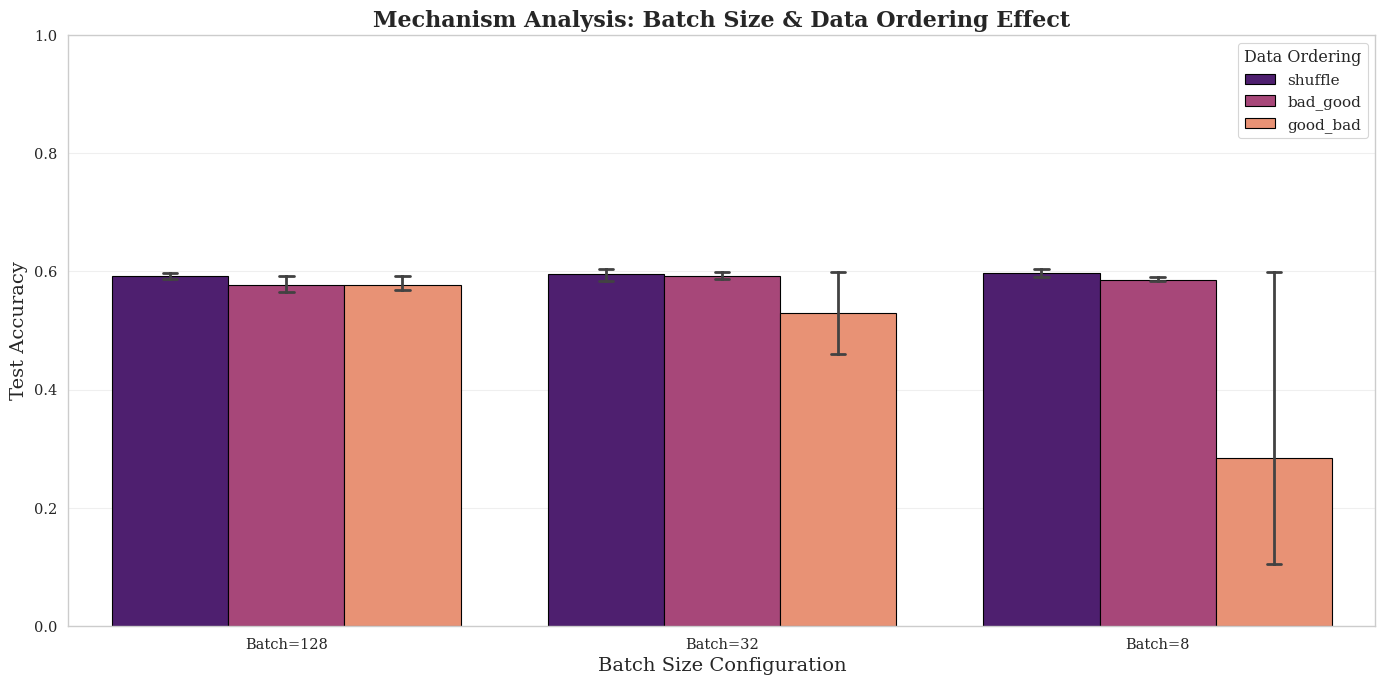

In [4]:
from figure_utils import save_ieee_figure
plt.figure(figsize=(14, 7))

# Create grouped bar chart
df['Condition'] = 'Batch=' + df['batch_size'].astype(str)

sns.barplot(
    data=df,
    x='Condition',
    y='mean_test_acc',
    hue='data_ordering',
    palette='magma',
    edgecolor='black',
    errwidth=2,
    capsize=0.1
)


plt.title('Mechanism Analysis: Batch Size & Data Ordering Effect', 
          fontsize=16, weight='bold')
plt.xlabel('Batch Size Configuration', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.ylim(0, 1.0)
plt.legend(title='Data Ordering', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
save_ieee_figure("batch_ordering_effect", "exp3", "cifar10", "01")
plt.show()

### 4.2 Heatmap: Batch Size × Ordering × Poison Ratio

✓ Saved IEEE figures: exp3_cifar10_02 (3.5" & 7.16")


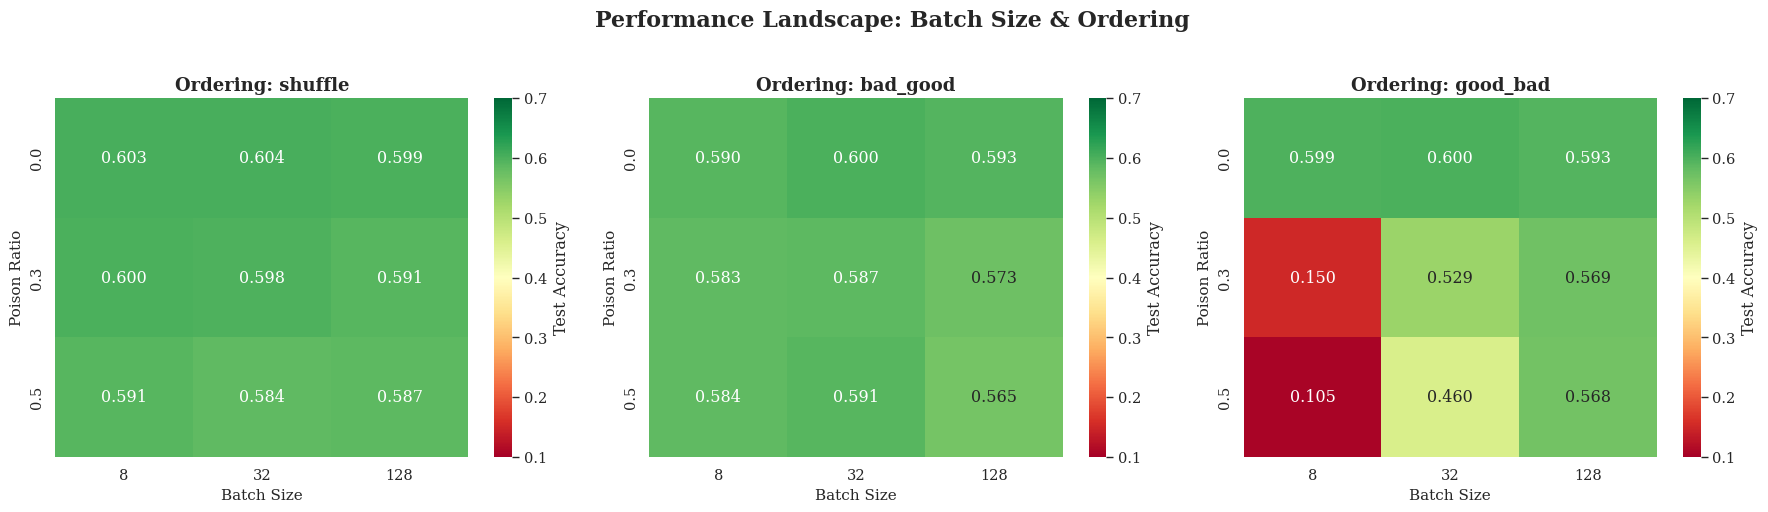

In [5]:
# Create subplots for each data ordering
orderings = df['data_ordering'].unique()
fig, axes = plt.subplots(1, len(orderings), figsize=(6*len(orderings), 5))

if len(orderings) == 1:
    axes = [axes]

for idx, ordering in enumerate(orderings):
    subset = df[df['data_ordering'] == ordering]
    pivot = subset.pivot_table(
        values='mean_test_acc',
        index='poison_ratio',
        columns='batch_size',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': 'Test Accuracy'},
                vmin=0.1, vmax=0.7, ax=axes[idx])
    axes[idx].set_title(f'Ordering: {ordering}', fontsize=13, weight='bold')
    axes[idx].set_xlabel('Batch Size', fontsize=11)
    axes[idx].set_ylabel('Poison Ratio', fontsize=11)

plt.suptitle('Performance Landscape: Batch Size & Ordering', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
save_ieee_figure("heatmap_batch_ordering", "exp3", "cifar10", "02")
plt.show()

### 4.3 Ordering Impact Quantification

✓ Saved IEEE figures: exp3_cifar10_03 (3.5" & 7.16")


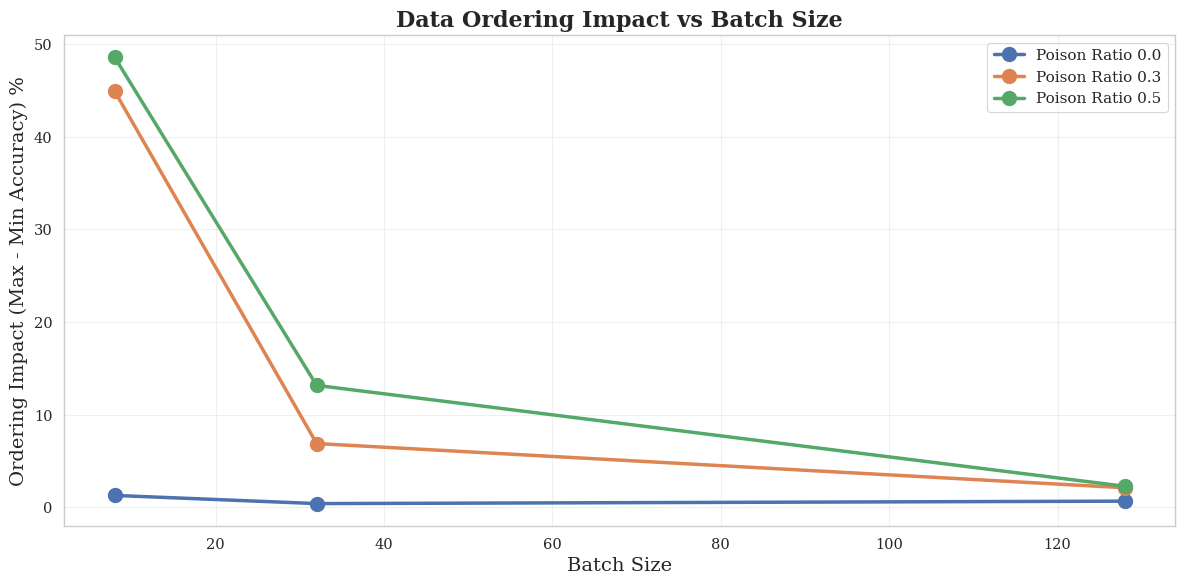

In [6]:
# Calculate ordering impact: difference between good-bad and bad-good
ordering_impact = []

for batch in df['batch_size'].unique():
    for pr in df['poison_ratio'].unique():
        # Get accuracies for different orderings
        orderings_dict = {}
        for ordering in df['data_ordering'].unique():
            acc = df[(df['batch_size'] == batch) & 
                     (df['poison_ratio'] == pr) & 
                     (df['data_ordering'] == ordering)]['mean_test_acc'].values
            if len(acc) > 0:
                orderings_dict[ordering] = acc[0]
        
        # Calculate impact if we have multiple orderings
        if len(orderings_dict) > 1:
            max_acc = max(orderings_dict.values())
            min_acc = min(orderings_dict.values())
            impact = max_acc - min_acc
            
            ordering_impact.append({
                'batch_size': batch,
                'poison_ratio': pr,
                'impact': impact * 100  # percentage
            })

impact_df = pd.DataFrame(ordering_impact)

# Plot
if len(impact_df) > 0:
    plt.figure(figsize=(12, 6))
    
    for pr in sorted(impact_df['poison_ratio'].unique()):
        subset = impact_df[impact_df['poison_ratio'] == pr].sort_values('batch_size')
        plt.plot(subset['batch_size'], subset['impact'],
                 marker='o', linewidth=2.5, markersize=10, 
                 label=f'Poison Ratio {pr}')
    
    plt.title('Data Ordering Impact vs Batch Size', fontsize=16, weight='bold')
    plt.xlabel('Batch Size', fontsize=14)
    plt.ylabel('Ordering Impact (Max - Min Accuracy) %', fontsize=14)
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_ieee_figure("ordering_impact", "exp3", "cifar10", "03")
    plt.show()

## 5. General Observations

### Key Findings:

1. **Batch Size Effect**
   - Larger batches: more stable gradients, lower variance
   - Smaller batches: noisy gradients, may dilute poison effect
   - Trade-off between convergence stability and attack resistance

2. **Data Ordering Sensitivity**
   - Good-Bad: clean data first, poisoned data later
   - Bad-Good: poisoned data first, clean data later
   - Shuffle: random mixing throughout training
   - Results reveal if model can "recover" from early poisoning

3. **Mechanism Insights**
   - If ordering has large impact: model is sensitive to training trajectory
   - If batch size matters: gradient variance plays a role in robustness
   - Links to momentum accumulation and learning rate scheduling

4. **Practical Implications**
   - Data ordering can be a defense: schedule clean data strategically
   - Batch size tuning for robustness vs convergence speed

## 6. Mathematical Analysis

### 6.1 Gradient Variance and Batch Size

The variance of stochastic gradients scales inversely with batch size:

$$
\text{Var}[\nabla L_{\text{batch}}] \approx \frac{\sigma^2}{B}
$$

where $B$ is batch size and $\sigma^2$ is variance of per-sample gradients.

### 6.2 Ordering Impact Metric

We define ordering impact $O$ as:

$$
O(B, p) = \max_{s \in S} \text{Acc}(B, p, s) - \min_{s \in S} \text{Acc}(B, p, s)
$$

where $S$ is the set of orderings (shuffle, bad-good, good-bad), $B$ is batch size, $p$ is poison ratio.

In [7]:
# Statistical analysis of ordering impact
if len(impact_df) > 0:
    print("Ordering Impact Statistics:\n")
    print(f"Mean Impact: {impact_df['impact'].mean():.2f}%")
    print(f"Max Impact: {impact_df['impact'].max():.2f}%")
    print(f"Std Dev: {impact_df['impact'].std():.2f}%")
    
    # Find conditions with highest ordering sensitivity
    max_impact_row = impact_df.loc[impact_df['impact'].idxmax()]
    print(f"\nMost Ordering-Sensitive Configuration:")
    print(f"  Batch Size: {max_impact_row['batch_size']}")
    print(f"  Poison Ratio: {max_impact_row['poison_ratio']}")
    print(f"  Impact: {max_impact_row['impact']:.2f}%")

Ordering Impact Statistics:

Mean Impact: 13.37%
Max Impact: 48.56%
Std Dev: 19.36%

Most Ordering-Sensitive Configuration:
  Batch Size: 8.0
  Poison Ratio: 0.5
  Impact: 48.56%


### 6.3 ANOVA: Batch Size × Ordering Interaction

In [8]:
# Two-way ANOVA for each poison ratio
from scipy.stats import f_oneway

for pr in df['poison_ratio'].unique():
    print(f"\n{'='*60}")
    print(f"Poison Ratio: {pr}")
    print(f"{'='*60}")
    
    subset = df[df['poison_ratio'] == pr]
    
    # Test batch size effect
    batch_groups = [subset[subset['batch_size'] == b]['mean_test_acc'].values 
                    for b in subset['batch_size'].unique()]
    batch_groups = [g for g in batch_groups if len(g) > 0]
    
    if len(batch_groups) > 1:
        f_stat_batch, p_val_batch = f_oneway(*batch_groups)
        print(f"\nBatch Size Effect:")
        print(f"  F-statistic: {f_stat_batch:.4f}")
        print(f"  p-value: {p_val_batch:.4f}")
        if p_val_batch < 0.05:
            print("  ✓ Batch size has significant effect (p < 0.05)")
        else:
            print("  ✗ No significant batch size effect (p >= 0.05)")
    
    # Test ordering effect
    ordering_groups = [subset[subset['data_ordering'] == o]['mean_test_acc'].values 
                       for o in subset['data_ordering'].unique()]
    ordering_groups = [g for g in ordering_groups if len(g) > 0]
    
    if len(ordering_groups) > 1:
        f_stat_ord, p_val_ord = f_oneway(*ordering_groups)
        print(f"\nData Ordering Effect:")
        print(f"  F-statistic: {f_stat_ord:.4f}")
        print(f"  p-value: {p_val_ord:.4f}")
        if p_val_ord < 0.05:
            print("  ✓ Data ordering has significant effect (p < 0.05)")
        else:
            print("  ✗ No significant ordering effect (p >= 0.05)")


Poison Ratio: 0.0

Batch Size Effect:
  F-statistic: 1.3040
  p-value: 0.3387
  ✗ No significant batch size effect (p >= 0.05)

Data Ordering Effect:
  F-statistic: 3.4265
  p-value: 0.1017
  ✗ No significant ordering effect (p >= 0.05)

Poison Ratio: 0.3

Batch Size Effect:
  F-statistic: 0.7675
  p-value: 0.5049
  ✗ No significant batch size effect (p >= 0.05)

Data Ordering Effect:
  F-statistic: 1.6732
  p-value: 0.2646
  ✗ No significant ordering effect (p >= 0.05)

Poison Ratio: 0.5

Batch Size Effect:
  F-statistic: 0.6561
  p-value: 0.5525
  ✗ No significant batch size effect (p >= 0.05)

Data Ordering Effect:
  F-statistic: 2.1661
  p-value: 0.1958
  ✗ No significant ordering effect (p >= 0.05)


## 7. Conclusions

### Key Takeaways:

1. **Batch Size Mechanism**
   - Gradient variance inversely related to batch size
   - Smaller batches may provide implicit regularization against poisoning
   - Trade-off with convergence stability

2. **Data Ordering Sensitivity**
   - Training trajectory matters for attack effectiveness
   - Models can potentially "recover" from early poisoning if clean data comes later
   - Strategic data scheduling as a defense mechanism

3. **Mechanism Behind Width Robustness**
   - Wider models have smoother loss landscapes
   - More capacity to "absorb" poisoned gradients without catastrophic forgetting
   - Implicit regularization through over-parameterization

4. **Practical Implications**
   - **Batch size tuning**: optimize for robustness-convergence trade-off
   - **Data scheduling**: prioritize clean data in later training phases
   - **Combined with width**: mechanisms are complementary

5. **Research Implications**
   - Training dynamics crucial for understanding federated learning robustness
   - Momentum and learning rate schedules interact with poisoning
   - Future work: adaptive batch sizes and dynamic data scheduling

---

**Next Steps**: See Experiment 4 for attack type generalization analysis.